# Basic Plots

This notebook makes some basic descriptive plots of the idealized CROCO simulations for the CFB on EBF manuscript.

Author: Jacob Wenegrat (wenegrat@umd.edu) 2/2021


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import xgcm
from glob import glob
from dask.diagnostics import ProgressBar
import sys
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer
#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

## LOAD MODEL OUTPUT

In [2]:
# Load simulation output for NM runs
# Naming convention here is that _NUM_ indicates the resolution refinement from the initial 10 km grid
# _NC_ indicates no CFB, _WC_ indicates with CFB. _WW_ indicates weaker wind, _SW_ indicates enhanced wind (relative to |Ua|=7 m/s)

fname_NC = '../data/model/jet_his_20_NC.nc'
fname_WC = '../data/model/jet_his_20_WC.nc'

chunks = chunks={'s_rho':10, 's_w':10}

dsWC = xr.open_dataset(fname_WC, chunks=chunks)
dsWC['zeta'] = 0*dsWC.hbl # didn't save zeta...oops.
dsWC = dsWC.rename(time='ocean_time')
dsWC, grid = xroms.roms_dataset(dsWC)

dsNC = xr.open_dataset(fname_NC, chunks=chunks)
dsNC['zeta'] = 0*dsNC.hbl # didn't save zeta...oops.
dsNC = dsNC.rename(time='ocean_time')
dsNC, grid = xroms.roms_dataset(dsNC)

# I only saved rho for space, here converting to a temperature field.
dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=0, s_rho=-1).mean()) + 1)/2e-4 + 20

dsNC

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 4002, eta_v: 4001, ocean_time: 41, s_rho: 60, s_w: 61, xi_rho: 1002, xi_u: 1001)
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.9917 -0.975 -0.9583 ... -0.025 -0.008333
  * s_w         (s_w) float32 -1.0 -0.9833 -0.9667 ... -0.03333 -0.01667 0.0
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
  * ocean_time  (ocean_time) float64 1.4e+07 1.408e+07 ... 1.737e+07 1.745e+07
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(41, 10, 4002, 1002), meta=np.ndarray>
    z_w_u       (ocean_time, s_w, eta_rho, xi_u) float32 dask.array<chunksize=(41, 10, 4002, 1001), meta=np.ndarray>
    z_w_v       (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(41, 10, 4001, 1002), meta=np.ndarray>
    z_w_psi     (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(41, 10, 4001, 1001), meta=np.ndarray>
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(41, 10, 4002, 1002), meta=np.ndarray>
    z_rho_u     (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(41, 10, 4002, 1001), meta=np.ndarray>
    z_rho_v     (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(41, 10, 4001, 1002), meta=np.ndarray>
    z_rho_psi   (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(41, 10, 4001, 1001), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 4002, 1002), meta=np.ndarray>
    z_rho_u0    (s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(10, 4002, 1001), meta=np.ndarray>
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(10, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(10, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(10, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(10, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(10, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    hc          float32 ...
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    time_step   (ocean_time, auxil) int32 dask.array<chunksize=(41, 4), meta=np.ndarray>
    scrum_time  (ocean_time) float64 dask.array<chunksize=(41,), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(41, 10, 4002, 1001), meta=np.ndarray>
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(41, 10, 4001, 1002), meta=np.ndarray>
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunk

In [ ]:
# Load simulation output for ML runs

chunks={'time':5, 's_rho':10}
fileprefix = '../data/model/JET_ML_CFB/'
# Load History Files
files = sorted(glob(fileprefix+'jet_his.*.nc'))

dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks)
#dsWC.attrs['h'] = 4000
#dsWC['s_rho'] = (np.linspace(0, N, N) - N + 1/2)/N
#dsWC['s_w'] = (np.linspace(0, N, N+1) - N)/N
#dsWC['s_rho'] = ds.s_rho
#dsWC['s_w'] = ds.s_w
#dsWC = dsWC.rename(time='ocean_time')
ds = xr.open_dataset('../data/model/jet_his.nc')

# For some reason I have to correct the grid metrics that aren't being output with this CROCO run.
dsWC['s_rho'] = ('s_rho', ds.s_rho)
dsWC['s_w'] = ('s_w', ds.s_w)
dsWC['Cs_r'] = ds.Cs_r
dsWC['Cs_w'] = ds.Cs_w
dsWC['h'] = (('eta_rho', 'xi_rho'), 4000  + 0*dsWC.hbl.isel(time=0))
dsWC['pm'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.hbl.isel(time=0))
dsWC['pn'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.hbl.isel(time=0))
dsWC['pm_u'] = (('eta_rho', 'xi_u'), 1/500 + 0*dsWC.u.isel(time=0, s_rho=0))
dsWC['pn_v'] = (('eta_v', 'xi_rho'), 1/500 + 0*dsWC.v.isel(time=0, s_rho=0))

dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1)

dsWC['rho'] = dsWC.temp
dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=0, s_rho=-1).mean()) + 1)/2e-4 + 20


In [181]:
dsWC

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 4002, eta_v: 4001, s_rho: 100, s_w: 101, time: 47, xi_rho: 1002, xi_u: 1001)
Coordinates:
  * time        (time) float64 9.969e+36 3.11e+07 ... 3.491e+07 3.499e+07
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
    z_w         (time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 101, 4002, 1002), meta=np.ndarray>
    z_w_u       (time, s_w, eta_rho, xi_u) float32 dask.array<chunksize=(5, 101, 4002, 1001), meta=np.ndarray>
    z_w_v       (time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(5, 101, 4001, 1002), meta=np.ndarray>
    z_w_psi     (time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(5, 101, 4001, 1001), meta=np.ndarray>
    z_rho       (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 100, 4002, 1002), meta=np.ndarray>
    z_rho_u     (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(5, 100, 4002, 1001), meta=np.ndarray>
    z_rho_v     (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(5, 100, 4001, 1002), meta=np.ndarray>
    z_rho_psi   (time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(5, 100, 4001, 1001), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float32 -3.903e+03 ... -1.814
    z_rho_u0    (s_rho, eta_rho, xi_u) float32 -3.903e+03 -3.903e+03 ... -1.814
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 -3.903e+03 -3.903e+03 ... -1.814
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 -3.903e+03 -3.903e+03 ... -1.814
    z_w0        (s_w, eta_rho, xi_rho) float32 -4e+03 -4e+03 -4e+03 ... 0.0 0.0
    z_w_u0      (s_w, eta_rho, xi_u) float32 -4e+03 -4e+03 -4e+03 ... 0.0 0.0
    z_w_v0      (s_w, eta_v, xi_rho) float32 -4e+03 -4e+03 -4e+03 ... 0.0 0.0
    z_w_psi0    (s_w, eta_v, xi_u) float32 -4e+03 -4e+03 -4e+03 ... 0.0 0.0 0.0
Dimensions without coordinates: auxil
Data variables:
    time_step   (time, auxil) int32 dask.array<chunksize=(5, 4), meta=np.ndarray>
    ocean_time  (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 4002, 1002), meta=np.ndarray>
    u           (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(5, 10, 4002, 1001), meta=np.ndarray>
    v           (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(5, 10, 4001, 1002), meta=np.ndarray>
    temp        (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 10, 4002, 1002), meta=np.ndarray>
    w           (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 10, 4002, 1002), meta=np.ndarray>
    sustr       (time, eta_rho, xi_u) float32 dask.array<chunksize=(5, 4002, 1001), meta=np.ndarray>
    svstr       (time, eta_v, xi_rho) float32 dask.array<chunksize=(5, 4001, 1002), meta=np.ndarray>
    hbl         (time, eta_rho, xi_rho) float32 dask.array<chunksize=(5, 4002, 1002), meta=np.ndarray>
    Cs_r        (s_rho) float32 ...
    Cs_w        (s_w) float32 ...
    h           (eta_rho, xi_rho) float32 4e+03 4e+03 4e+03 ... 4e+03 4e+03
    pm          (eta_rho, xi_rho) float32 0.002 0.002 0.002 ... 0.002 0.002
    pn          (eta_rho, xi_rho) float32 0.002 0.002 0.002 ... 0.002 0.002
    pm_u        (eta_rho, xi_u) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    pn_v        (eta_v, xi_rho) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    pm_v        (eta_v, xi_rho) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    pn_u        (eta_rho, xi_u) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    pm_psi      (eta_v, xi_u) float32 0.002 0.002 0.002 ... 0.002 0.002 0.002
    pn_psi      (eta_

In [157]:
dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks)
dsWC = xr.open_dataset('../data/model/JET_ML_CFB/jet_his.00035.nc')
dsWC['s_rho'] = ('s_rho', ds.s_rho)
dsWC['s_w'] = ('s_w', ds.s_w)
dsWC['Cs_r'] = ds.Cs_r
dsWC.attrs['h'] = 4000 
dsWC

Zo_rho = dsWC.hc * (dsWC.s_rho - ds.Cs_r) + dsWC.Cs_r * dsWC.h
z_rho = Zo_rho + dsWC.zeta * (1 + Zo_rho / dsWC.h)
Zo_w = dsWC.hc * (dsWC.s_w - dsWC.Cs_w) + dsWC.Cs_w * dsWC.h
        #z_w = Zo_w + ds.zeta * (1 + Zo_w / ds.h)
        # also include z coordinates with mean sea level (constant over time)
        #z_rho0 = Zo_rho
        #z_w0 = Zo_w
#dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1)

Zo_rho

<xarray.DataArray (s_rho: 100)>
array([-3.90319971e+03, -3.71667285e+03, -3.53919360e+03, -3.37032007e+03,
       -3.20963281e+03, -3.05673267e+03, -2.91123950e+03, -2.77279248e+03,
       -2.64104712e+03, -2.51567700e+03, -2.39637134e+03, -2.28283398e+03,
       -2.17478345e+03, -2.07195239e+03, -1.97408594e+03, -1.88094202e+03,
       -1.79229004e+03, -1.70791089e+03, -1.62759619e+03, -1.55114758e+03,
       -1.47837622e+03, -1.40910291e+03, -1.34315662e+03, -1.28037524e+03,
       -1.22060425e+03, -1.16369653e+03, -1.10951245e+03, -1.05791895e+03,
       -1.00878937e+03, -9.62003601e+02, -9.17446960e+02, -8.75010742e+02,
       -8.34591125e+02, -7.96089722e+02, -7.59412598e+02, -7.24470764e+02,
       -6.91179016e+02, -6.59456909e+02, -6.29227417e+02, -6.00417603e+02,
       -5.72957886e+02, -5.46782043e+02, -5.21827148e+02, -4.98033325e+02,
       -4.75343567e+02, -4.53703644e+02, -4.33061951e+02, -4.13369324e+02,
       -3.94579041e+02, -3.76646698e+02, -3.59529846e+02, -3.43188232e+02,
       -3.27583496e+02, -3.12679169e+02, -2.98440369e+02, -2.84834076e+02,
       -2.71828735e+02, -2.59394318e+02, -2.47502258e+02, -2.36125336e+02,
       -2.25237564e+02, -2.14814240e+02, -2.04831772e+02, -1.95267746e+02,
       -1.86100708e+02, -1.77310242e+02, -1.68876877e+02, -1.60782043e+02,
       -1.53007965e+02, -1.45537735e+02, -1.38355148e+02, -1.31444748e+02,
       -1.24791779e+02, -1.18382080e+02, -1.12202141e+02, -1.06238998e+02,
       -1.00480247e+02, -9.49139862e+01, -8.95288086e+01, -8.43137207e+01,
       -7.92582092e+01, -7.43521271e+01, -6.95856934e+01, -6.49495087e+01,
       -6.04344711e+01, -5.60317993e+01, -5.17329712e+01, -4.75297470e+01,
       -4.34141159e+01, -3.93782883e+01, -3.54146729e+01, -3.15158539e+01,
       -2.76745892e+01, -2.38837681e+01, -2.01364174e+01, -1.64256649e+01,
       -1.27447338e+01, -9.08691883e+00, -5.44557476e+00, -1.81409621e+00],
      dtype=float32)
Coordinates:
  * s_rho    (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
Attributes:
    long_name:      S-coordinate at RHO-points
    axis:           Z
    positive:       up
    standard_name:  ocean_s_coordinate_g1
    formula_terms:  s: sc_r C: Cs_r eta: zeta depth: h depth_c: hc

In [186]:
dsWC.temp[0,-1,0,0]

<xarray.DataArray 'temp' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     float64 9.969e+36
    s_rho    float32 -0.005
    xi_rho   int64 0
    eta_rho  int64 0
    z_rho    float32 dask.array<chunksize=(), meta=np.ndarray>
    z_rho0   float32 -1.814
Attributes:
    long_name:      potential temperature
    units:          Celsius
    field:          temperature, scalar, series
    standard_name:  sea_water_potential_temperature
    coordinates:    x_rho y_rho
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

In [176]:
ds = xr.open_dataset('../data/model/JET_ML_CFB/jet_rst_ML_4.nc')
#ds = xr.open_dataset('../data/model/jet_his.nc')
#ds = xr.open_dataset('../../RESTARTS/jet_rst_smode.nc')
#ds, grid = xroms.roms_dataset(ds, Vtransform=1)
#plt.plot(dsWC.hbl.mean(('eta_rho', 'xi_rho')))
#plt.plot(ds.hbl.mean(('eta_rho', 'xi_rho')))

In [177]:
ds

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 4002, eta_v: 4001, s_rho: 100, xi_rho: 1002, xi_u: 1001)
Coordinates:
    time        float64 ...
  * xi_rho      (xi_rho) float64 0.0 0.2507 0.5015 0.7522 ... 250.5 250.7 251.0
  * eta_rho     (eta_rho) float64 0.0 0.2502 0.5004 ... 1.001e+03 1.001e+03
  * xi_u        (xi_u) float64 0.0 0.25 0.5 0.75 1.0 ... 249.2 249.5 249.8 250.0
  * eta_v       (eta_v) float64 0.0 0.25 0.5 0.75 ... 999.2 999.5 999.8 1e+03
Dimensions without coordinates: auxil, s_rho
Data variables:
    time_step   (auxil) int32 ...
    ocean_time  float64 ...
    zeta        (eta_rho, xi_rho) float64 ...
    ubar        (eta_rho, xi_u) float64 ...
    vbar        (eta_v, xi_rho) float64 ...
    u           (s_rho, eta_rho, xi_u) float64 ...
    v           (s_rho, eta_v, xi_rho) float64 ...
    temp        (s_rho, eta_rho, xi_rho) float64 ...
Attributes:
    type:          ROMS restart file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.nc
    skpp:          2005
    theta_s:       5.0
    theta_s_expl:  S-coordinate surface control parameter
    theta_b:       0.0
    theta_b_expl:  S-coordinate bottom control parameter
    Tcline:        100.0
    Tcline_expl:   S-coordinate surface/bottom layer width
    Tcline_units:  meter
    hc:            100.0
    hc_expl:       S-coordinate parameter, critical depth
    hc_units:      meter
    sc_w:          [-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0....
    sc_w_expl:     S-coordinate at W-points
    Cs_w:          [-1.00000000e+00 -9.51224882e-01 -9.04828322e-01 -8.606943...
    Cs_w_expl:     S-coordinate stretching curves at W-points
    sc_r:          [-0.995 -0.985 -0.975 -0.965 -0.955 -0.945 -0.935 -0.925 -...
    sc_r_expl:     S-coordinate at W-points
    Cs_r:          [-9.75307642e-01 -9.27736670e-01 -8.82485523e-01 -8.394410...
    Cs_r_expl:     S-coordinate stretching curves at RHO-points
    ntimes:        88800
    ndtfast:       80
    dt:            360.0
    dtfast:        4.5
    nwrt:          2400
    visc2:         0.0
    visc2_expl:    Laplacian mixing coefficient for momentum
    visc2_units:   meter2 second-1
    rdrg:          0.0015
    rdrg_expl:     linear drag coefficient
    rdrg_units:    meter second-1
    rho0:          1027.397241
    rho0_expl:     Mean density used in Boussinesq approximation
    rho0_units:    kilogram meter-3
    R0:            0.0
    R0_expl:       Background density used in linear equation of state
    R0_units:      kilogram meter-3
    Tcoef:         -1.0
    Tcoef_expl:    thermal expansion coefficient
    Tcoef_units:   kg.m-3.C-1
    Scoef:         0.0
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 UV_VADV_...

In [3]:
ny = np.array(dsWC.eta_rho.size)
nyc = int(ny/2)
nysp = int(ny/8)
yl = slice(nyc-nysp, nyc+nysp)

In [182]:
# Vorticity Calculation
vx = grid.derivative(dsNC.v, 'X')
uy = grid.derivative(dsNC.u, 'Y')
vy = grid.derivative(dsNC.v, 'Y', boundary='extend')
ux = grid.derivative(dsNC.u, 'X', boundary='extend')

dsNC['vort'] = vx - uy
dsNC['div'] = vy + ux
dsNC['strain'] = np.sqrt((xroms.to_rho(ux, grid)-xroms.to_rho(vy,grid))**2 + (xroms.to_rho(vx,grid) + xroms.to_rho(uy,grid))**2)

vx = grid.derivative(dsWC.v, 'X')
uy = grid.derivative(dsWC.u, 'Y')
vy = grid.derivative(dsWC.v, 'Y', boundary='extend')
ux = grid.derivative(dsWC.u, 'X', boundary='extend')

dsWC['vort'] = vx - uy
dsWC['div'] = vy + ux
dsWC['strain'] = vy - ux # Note the alternate possible strain rate def (below)
#dsWC['strain'] = np.sqrt((xroms.to_rho(ux, grid)-xroms.to_rho(vy,grid))**2 + (xroms.to_rho(vx,grid) + xroms.to_rho(uy,grid))**2)

In [183]:
# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), grid)
#dsWC['JF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020*(dsWC.hbl+2))
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020)
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*grid.derivative(dsNC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), grid)
#dsNC['JF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020*(dsNC.hbl+2))
dsNC['EBF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020)
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)

AttributeError: 'Dataset' object has no attribute 'rho'

## Nice descriptive plots

/homes/metofac/wenegrat/miniconda3/envs/CFB_EBF/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


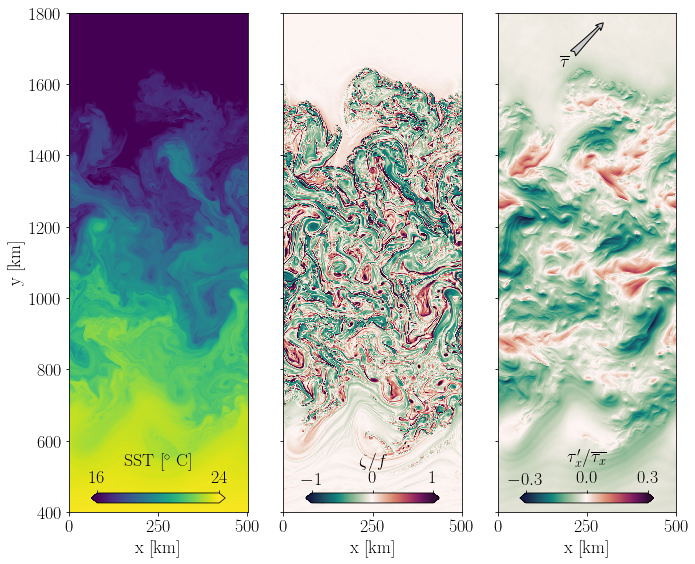

In [6]:
# Nice side-by-side SST, vorticity, stress perturbation plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
rs = True
# Plot Vorticity
Day = 200
#Day = 185
fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=True)


# Divergence
#divnorm = dsWC.div.isel(s_rho=-3).sel(ocean_time=Day*86400)/dsWC.f
#ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, divnorm, vmin=-1, vmax=1, cmap = cmo.curl)

#ax[2].set_ylim(300, 1900)
#ax[2].set_aspect('equal')


# Iterate through subplots
for i in range(0,3):
    if i==0:
        vl = 16
        vr = 24
        ix = ax[0].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, dsWC.temp.isel(s_rho=-1).sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap='viridis', rasterized=rs)
        label=r'SST [$^\circ$ C]'
    elif i==1:
        vl = -1
        vr = 1
        vortnorm = xroms.to_rho(dsWC.vort.isel(s_rho=-1).sel(ocean_time=Day*86400), grid)/dsWC.f
        ix = ax[1].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, vortnorm, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs)
        label=r'$\zeta/f$'
    else:
        vl = -0.3
        vr = 0.3
        label = r'$\tau_x^\prime/\overline{\tau_x}$'
        txmag = (1e-3*np.sqrt(2*5**2)*5)
        txpert = (dsWC.sustr.sel(ocean_time=Day*86400) - txmag)/txmag
        ix = ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, txpert, vmin=vl, vmax=vr, cmap = cmo.curl, rasterized=rs)

    ax[i].set_ylim(400, 1800)
    ax[i].set_aspect('equal')

    axins = inset_axes(ax[i],
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='lower center')
    cb = plt.colorbar(ix, ax=ax[i], cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
    cb.set_label(label)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    ax[i].set_xticks([0, 250, 500])

ax[0].set_ylabel('y [km]')
ax[0].set_xlabel('x [km]')
ax[1].set_xlabel('x [km]')
ax[2].set_xlabel('x [km]')

cf = 100 # 20 is 10 km
xslice = slice(0, 1000, cf)
yslice = slice(0, 4000, cf)
suc = xroms.to_rho(dsWC.sustr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
svc = xroms.to_rho(dsWC.svstr.sel(ocean_time=Day*86400), grid).isel(xi_rho=xslice, eta_rho=yslice)
xrhoc = dsWC.x_rho.isel(xi_rho=xslice, eta_rho=yslice)

#ax[2].quiver(xrhoc.x_rho/1000, xrhoc.y_rho/1000, suc, svc)
#ax[2].quiver(200, 1600, txmag, txmag, scale=2e-1)
ax[2].annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
               dict(arrowstyle='fancy', 
                    fc='0.8',
                    ec = 'k'))
plt.tight_layout()

plt.rcParams['font.size'] = 14
#plt.savefig('./Figures/3Panel.pdf', bbox_inches='tight', dpi=250)

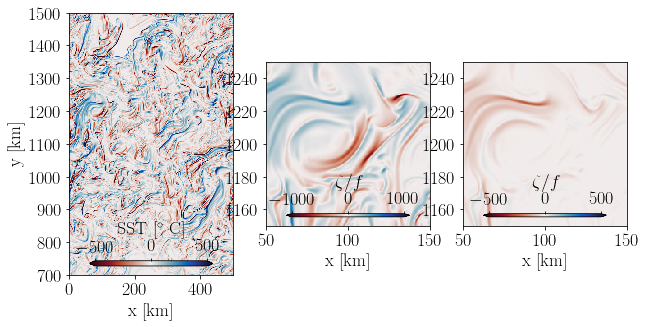

In [22]:
# Nice side-by-side SST, vorticity, stress perturbation plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
rs = True
# Plot Vorticity
Day = 200
#Day = 185
fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=False)


# Iterate through subplots
for i in range(0,3):
    if i==0:
        btowatts=(1020*4000)/(2e-4*9.8)
        vl = -500
        vr = 500
        ix = ax[0].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*dsWC.EBF.sel(ocean_time=Day*86400),vmin=vl, vmax=vr, cmap=cmo.balance_r, rasterized=rs)
        label=r'SST [$^\circ$ C]'
        ax[i].set_ylim(700, 1500)

    elif i==1:
        EBFprime = (dsWC.EBF)
        vl = -1000
        vr = 1000
        ix = ax[1].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
        label=r'$\zeta/f$'
        
        ax[i].set_ylim(1150, 1250)
        ax[i].set_xlim(50, 150)
        
    else:
        EBFprime = (dsWC.EBF - dsWC.EBFm)
        vl = -500
        vr = 500
        ix = ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*EBFprime.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
        label=r'$\zeta/f$'
        
        ax[i].set_ylim(1150, 1250)
        ax[i].set_xlim(50, 150)
        
    ax[i].set_aspect('equal')

    axins = inset_axes(ax[i],
                    width="75%",  # width = 50% of parent_bbox width
                    height="2%",  # height : 5%
                    loc='lower center')
    cb = plt.colorbar(ix, ax=ax[i], cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
    cb.set_label(label)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    #ax[i].set_xticks([0, 250, 500])

ax[0].set_ylabel('y [km]')
ax[0].set_xlabel('x [km]')
ax[1].set_xlabel('x [km]')
ax[2].set_xlabel('x [km]')


#ax[2].annotate(r'${\overline{\tau}}$', (300, 1775), (175, 1650), arrowprops = 
#               dict(arrowstyle='fancy', 
#                    fc='0.8',
#                    ec = 'k'))
#plt.tight_layout()

plt.rcParams['font.size'] = 14
#plt.savefig('./Figures/3Panel.pdf', bbox_inches='tight', dpi=250)

In [26]:
btowatts*15e-6

31224.48979591836

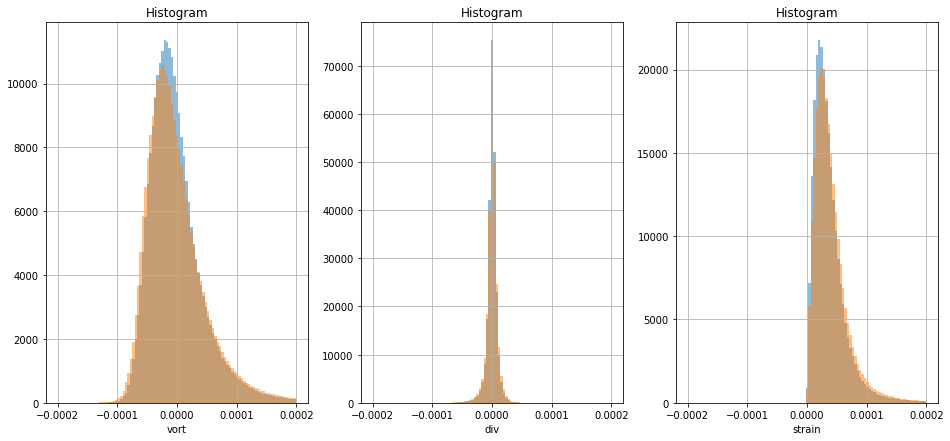

In [35]:
# Vorticity/Div/Strain Histogram
fig, ax = plt.subplots(1,3,figsize=(16,7), sharey=False)

sl = -15 # s_rho index to start at (goes to surface) -15 is z=100
sl = -2
#sl = -1
tl = -2  # time index to start at (goes to end)
#yl = slice(750,1500)

dens = True # normalize
# Vorticity
bins = np.linspace(-2e-4, 2e-4, 100)
dsWC.vort.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_v=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
dsNC.vort.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_v=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
ax[0].grid()

# Div
dsWC.div.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_rho=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
dsNC.div.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_rho=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
ax[1].grid()

# Strain
dsWC.strain.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
dsNC.strain.isel(s_rho=range(sl,0), ocean_time=range(tl,0), eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
ax[2].grid()

#ax[0].set_ylim(0, 2e5)

In [139]:
# Calculate GEO velocity and check with scatter plot
vgz =  xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho, 'X'), grid)/dsWC.f
ugz = -xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho, 'Y'), grid)/dsWC.f

dsWC['ug'] = grid.integrate(ugz.isel(s_rho=slice(30,60)), 'Z') + xroms.to_rho(dsWC.u.isel(s_rho=30), grid)
dsWC['vg'] = grid.integrate(ugz.isel(s_rho=slice(30,60)), 'Z') + xroms.to_rho(dsWC.v.isel(s_rho=30), grid)

#TS = -1
#plt.scatter(dsWC.ug.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')), xroms.to_rho(dsWC.u.isel(ocean_time=TS, s_rho=-1),grid).stack(z=('xi_rho', 'eta_rho')))
#plt.grid()


In [71]:
TS = -1
ugmag = np.mean((dsWC.ug.isel(ocean_time=-1, eta_rho=yl).values**2 + dsWC.vg.isel(ocean_time=-1, eta_rho=yl).values**2)**(1/2))
bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), grid)
bmag = np.sqrt(bx**2 + by**2)
thetab = np.arctan2(by.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')), bx.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')))

avgwindproj = np.mean(7*np.sin(np.pi/4 - thetab))
print(f'Ratio of geo vel to wind speed: {ugmag/avgwindproj.values}')

Ratio of geo vel to wind speed: 0.4295327365398407


In [72]:
3/2*ugmag/avgwindproj.values

0.6442991196639148

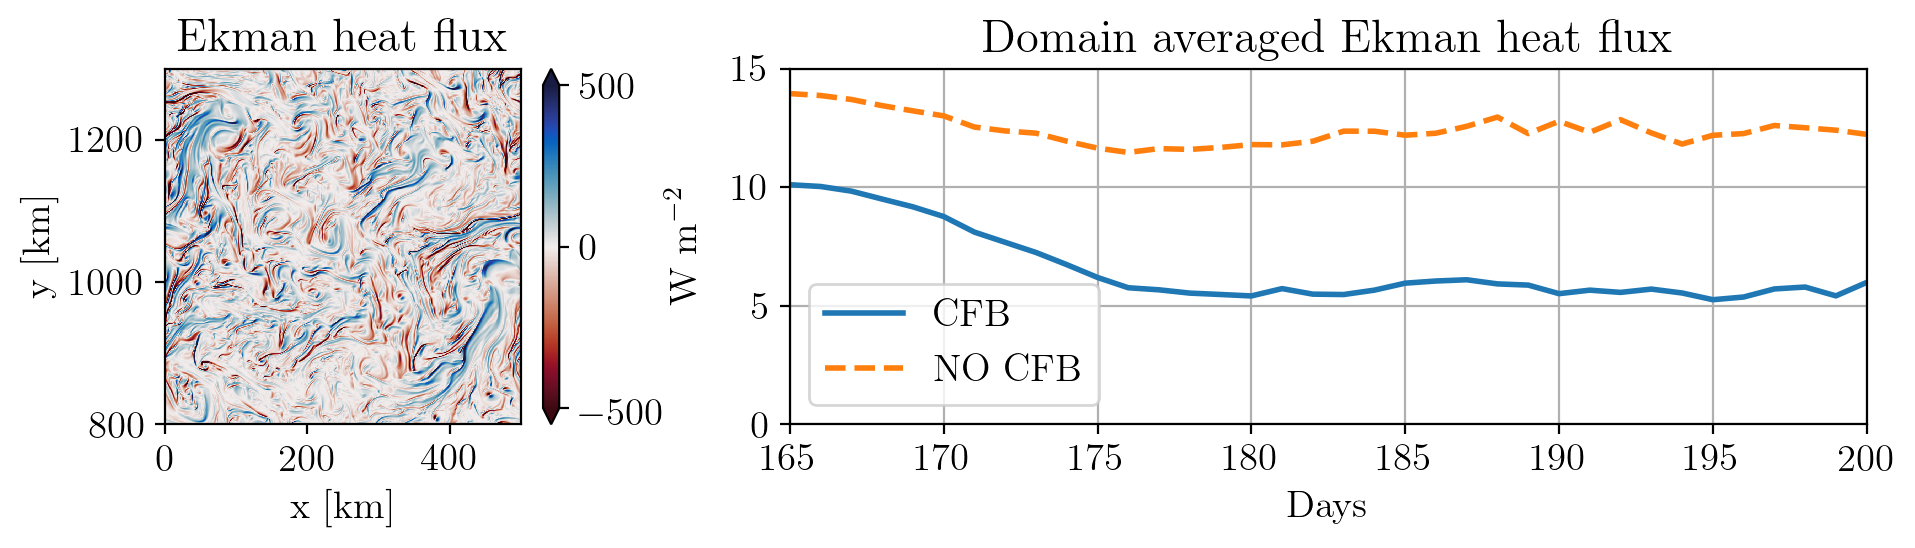

In [250]:
# Fancy EBF plots NO PV
plt.rcParams['text.usetex'] = True
rs = True
# Plot Vorticity
Day = 200
#Day = 185
#fig, ax = plt.subplots(1,3, figsize=(10, 14), sharey=True, dpi=300)
fig = plt.figure(figsize=(10*1.1,2.2*1.07), dpi=200)
btowatts=(1020*4000)/(2e-4*9.8)
# Divergence
#divnorm = dsWC.div.isel(s_rho=-3).sel(ocean_time=Day*86400)/dsWC.f
#ax[2].pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, divnorm, vmin=-1, vmax=1, cmap = cmo.curl)

#ax[2].set_ylim(300, 1900)
#ax[2].set_aspect('equal')


# Iterate through subplots

vl = -500
vr = 500
ax = plt.subplot2grid((1,3), (0,0), rowspan = 1, colspan=1)
ix = ax.pcolormesh(dsWC.x_rho/1000, dsWC.y_rho/1000, btowatts*dsWC.EBF.sel(ocean_time=Day*86400), vmin=vl, vmax=vr, cmap = cmo.balance_r, rasterized=rs)
label=r'W m$^{-2}$'
   
ax.set_ylim(800, 1300)
ax.set_xlim(0, 500)
ax.set_aspect('equal')
ax.set_title('Ekman heat flux')
#ax.text(25, 1725 ,'a)', color='k', size=14, bbox=dict(facecolor='w', edgecolor='k'))
cb = plt.colorbar(ix, ax=ax, extend='both', ticks=[vl, 0, vr])

#axins = inset_axes(ax,
#                    width="75%",  # width = 50% of parent_bbox width
#                    height="2%",  # height : 5%
#                    loc='lower center')

#cb = plt.colorbar(ix, ax=ax, cax=axins, orientation='horizontal', extend='both', ticks=[vl, 0, vr])
#cb.ax.xaxis.set_ticks_position('top')
#cb.ax.xaxis.set_label_position('top')
#cb.set_label(label)

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
    #ax[i].set_xticks([0, 250, 500])

#ax[0].set_ylabel('y [km]')
#ax[0].set_xlabel('x [km]')
#ax[1].set_xlabel('x [km]')
#ax[2].set_xlabel('x [km]')
ax = plt.subplot2grid((1,3), (0,1), rowspan = 1, colspan=2)
EBF_WC = dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))
EBF_NC = dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))

ax.plot(dsWC.ocean_time[1:]/86400, EBF_WC[1:]*btowatts, linewidth=2, label='CFB')
ax.plot(dsNC.ocean_time[1:]/86400, EBF_NC[1:]*btowatts, linewidth=2, linestyle='--', label='NO CFB')
ax.grid()
ax.set_ylim(0, 15)
ax.set_ylabel('W m$^{-2}$', labelpad=10)
ax.set_xlim(165, 200)
#ax.set_xticklabels([])
ax.set_xlabel('Days')
#ax.text(165.75, 1.1 ,'b)', color='k', size=14, bbox=dict(facecolor='w', edgecolor='k'))
ax.legend()
ax.set_title('Domain averaged Ekman heat flux')
plt.subplots_adjust( wspace = 0.4)
#plt.tight_layout()
#plt.savefig('./Figures/EBFPanelsNOPV.pdf', bbox_inches='tight', dpi=300)
#plt.rcParams['text.usetex'] = False

In [27]:
EBFprime = dsWC.EBF - dsWC.EBFm
sels = slice(190, 200)
print(f'Maximum EBF in W/m2: {btowatts*dsWC.EBF.max().values}')
print(f'Minimum EBF in W/m2: {btowatts*dsWC.EBF.min().values}')

print(f'Maximum EBF prime in W/m2: {btowatts*EBFprime.sel(time=sels*86400).max().values}')
print(f'Minimum EBF prime in W/m2: {btowatts*EBFprime.sel(time=sels*86400).min().values}')
ratio = np.abs(EBFprime.values)/np.abs(dsWC.EBF.values)
ratio[~np.isfinite(ratio)] = np.nan
print(f'Percentage abs difference: {np.nanmax(ratio)}')

Maximum EBF in W/m2: 1571.551899118907
Minimum EBF in W/m2: -3214.0198425399917


TypeError: unsupported operand type(s) for *: 'slice' and 'int'

In [272]:
sels = slice(190*86400, 200*86400)
print(f'Maximum EBF prime in W/m2: {btowatts*EBFprime.sel(ocean_time=sels).max().values}')
print(f'Minimum EBF prime in W/m2: {btowatts*EBFprime.sel(ocean_time=sels).min().values}')

Maximum EBF prime in W/m2: 288.61711366424015
Minimum EBF prime in W/m2: -586.0452194276742


## Confirm scaling arguments

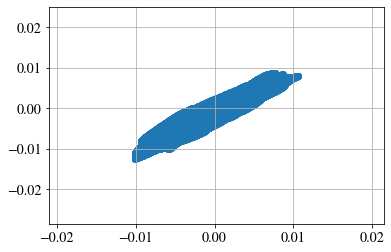

In [26]:
TS = -1
txp = dsWC.sustr.isel(ocean_time=TS) - dsWC.sustr.isel(ocean_time=TS).mean(('xi_u', 'eta_rho'))
txptheory = -1e-3*7*dsWC.u.isel(s_rho=-1, ocean_time=TS)
plt.figure()
plt.scatter(txp.stack(z=('xi_u', 'eta_rho')), 3/2*txptheory.stack(z=('xi_u', 'eta_rho')))
plt.grid()

# Check orientation of surface currents with buoyancy gradient
#bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1, ocean_time=TS), 'X'), grid).isel(eta_rho=yl)
#by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1, ocean_time=TS), 'Y'), grid).isel(eta_rho=yl)
#thetab = np.arctan2(by.stack(z=('xi_rho', 'eta_rho')), bx.stack(z=('xi_rho', 'eta_rho')))
#v = xroms.to_rho(dsWC.v.isel(ocean_time=TS, s_rho=-1), grid).isel(eta_rho=yl)
#u = xroms.to_rho(dsWC.u.isel(ocean_time=TS, s_rho=-1), grid).isel(eta_rho=yl)
#thetau = np.arctan2(v.stack(z=('xi_rho', 'eta_rho')), u.stack(z=('xi_rho', 'eta_rho')))

#plt.figure()
#plt.scatter(thetau, thetab)

In [206]:
# Calculate and plot surface KE
up_WC = dsWC.u.isel(s_rho=-1, eta_rho=yl) - dsWC.u.isel(s_rho=-1, eta_rho=yl).mean(dim=('xi_u', 'eta_rho'))
vp_WC = dsWC.v.isel(s_rho=-1, eta_v=yl) - dsWC.v.isel(s_rho=-1, eta_v=yl).mean(dim=('xi_rho', 'eta_v'))
KE_WC = 0.5*(np.mean(up_WC**2, axis=(1,2)) + np.mean(vp_WC**2, axis=(1,2)))

up_NC = dsNC.u.isel(s_rho=-1, eta_rho=yl) - dsNC.u.isel(s_rho=-1, eta_rho=yl).mean(dim=('xi_u', 'eta_rho'))
vp_NC = dsNC.v.isel(s_rho=-1, eta_v=yl) - dsNC.v.isel(s_rho=-1, eta_v=yl).mean(dim=('xi_rho', 'eta_v'))
KE_NC = 0.5*(np.mean(up_NC**2, axis=(1,2)) + np.mean(vp_NC**2, axis=(1,2)))

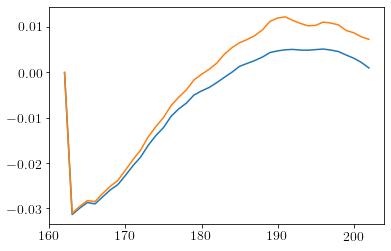

In [207]:
# Plot KE in time
plt.plot(dsWC.ocean_time/86400, KE_WC - KE_WC[0])
plt.plot(dsNC.ocean_time/86400, KE_NC - KE_NC[0])


In [11]:
print(f'Ratio of coupled/uncoupled surface KE: {KE_WC.values[-1]/KE_NC.values[-1]}')

Ratio of coupled/uncoupled surface KE: 0.876564621925354


In [9]:
# Calculate and plot total KE
up_WC = dsWC.u - dsWC.u.mean(dim=('xi_u', 'eta_rho'))
vp_WC = dsWC.v - dsWC.v.mean(dim=('xi_rho', 'eta_v'))
KE_WCi = 0.5*(grid.integrate(up_WC**2, ['X', 'Y', 'Z']) + grid.integrate(vp_WC**2, ['X', 'Y', 'Z']))
#KE_WC = 0.5*(np.mean(up_WC**2, axis=(1,2)) + np.mean(vp_WC**2, axis=(1,2)))

up_NC = dsNC.u - dsNC.u.mean(dim=('xi_u', 'eta_rho'))
vp_NC = dsNC.v - dsNC.v.mean(dim=('xi_rho', 'eta_v'))
KE_NCi = 0.5*(grid.integrate(up_NC**2, ['X', 'Y', 'Z']) + grid.integrate(vp_NC**2, ['X', 'Y', 'Z']))


KeyboardInterrupt: 

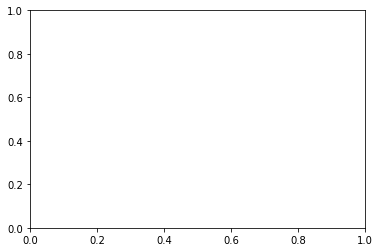

In [10]:
# Plot Integrated KE in time
plt.plot(dsWC.ocean_time/86400, KE_WCi - KE_WCi[0])
plt.plot(dsNC.ocean_time/86400, KE_NCi - KE_NCi[0])

Ratio of coupled/uncoupled wind work: 0.9012599587440491


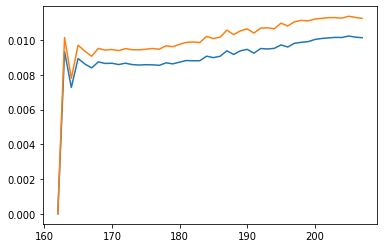

In [14]:
# Wind work
ww_WC = grid.average(dsWC.sustr.isel(eta_rho=yl)*dsWC.u.isel(s_rho=-1, eta_rho=yl), ('X','Y')) + grid.average(dsWC.svstr.isel(eta_v=yl)*dsWC.v.isel(s_rho=-1, eta_v=yl), ('X','Y'))
ww_NC = grid.average(dsNC.sustr.isel(eta_rho=yl)*dsNC.u.isel(s_rho=-1, eta_rho=yl), ('X','Y')) + grid.average(dsNC.svstr.isel(eta_v=yl)*dsNC.v.isel(s_rho=-1, eta_v=yl), ('X','Y'))

plt.plot(dsWC.ocean_time/86400, ww_WC)
plt.plot(dsNC.ocean_time/86400, ww_NC)

print(f'Ratio of coupled/uncoupled wind work: {ww_WC.values[-1]/ww_NC.values[-1]}')

In [16]:
print(f'Ratio of coupled/uncoupled wind work: {ww_WC.values[-1]/ww_NC.values[-1]}')

Ratio of coupled/uncoupled wind work: 0.9012599587440491


In [41]:
print(f'Ratio of Coupled/Uncoupled: {ww_WC.values[-1]/ww_NC.values[-1]}')
print(f'Ratio of Cumulative Coupled/Uncoupled: {ww_WCi[-1]/ww_NCi[-1]}')


Ratio of Coupled/Uncoupled: 0.772448718547821
Ratio of Cumulative Coupled/Uncoupled: 0.7745150132866715


## SPECTRAL ANALYSIS

(1000, 1000)
(20, 20)
(1000, 1000)
(20, 20)


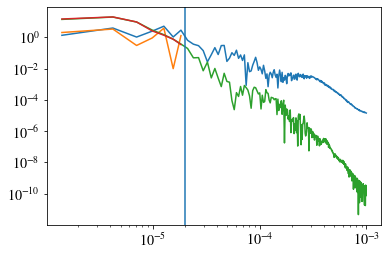

In [96]:
# Vorticity and divergence spectra
TS = -1
ZS = -1

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
T = dsWC.temp.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl).values[:,1:-1]
TX = dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).values[:,:-1]
spectx = spec.CO_TWODimensional_spec(T, TX,dx,dy)
plt.loglog(spectx.ki, np.abs(spectx.ispec))
TC =dsWC.temp.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl).coarsen(xi_rho=50, eta_rho=50, boundary='trim').mean()
TXC=dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).coarsen(xi_u=50, eta_rho=50, boundary='trim').mean()
spectx = spec.CO_TWODimensional_spec(TC, TXC,dx*50,dy*50)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

TS = 1
T = dsWC.temp.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl).values[:,1:-1]
TX = dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).values[:,:-1]
spectx = spec.CO_TWODimensional_spec(T, TX,dx,dy)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

TC =dsWC.temp.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl).coarsen(xi_rho=50, eta_rho=50, boundary='trim').mean()
TXC=dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).coarsen(xi_u=50, eta_rho=50, boundary='trim').mean()
spectx = spec.CO_TWODimensional_spec(TC, TXC,dx*50,dy*50)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

plt.axvline(1/50e3)

In [115]:
TXC

<xarray.DataArray (eta_rho: 80, xi_u: 20)>
dask.array<mean_agg-aggregate, shape=(80, 20), dtype=float32, chunksize=(20, 20), chunktype=numpy.ndarray>
Coordinates:
  * xi_u        (xi_u) float32 26.0 76.0 126.0 176.0 ... 826.0 876.0 926.0 976.0
  * eta_rho     (eta_rho) float32 25.5 75.5 125.5 175.5 ... 3875.5 3925.5 3975.5
    ocean_time  float64 1.728e+07

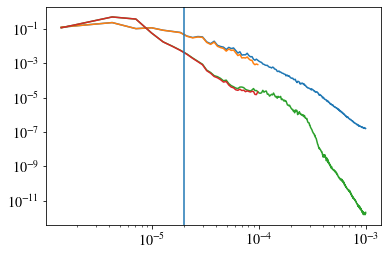

In [97]:
# WIND SPECTRA
TS = -1
ZS = -1
coarsen = 10
#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
TX = dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).values[:,:-1]
spectx = spec.TWODimensional_spec(TX,dx,dy)
plt.loglog(spectx.ki, np.abs(spectx.ispec))
TXC=dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).coarsen(xi_u=coarsen, eta_rho=coarsen, boundary='trim').mean()
spectx = spec.TWODimensional_spec( TXC,dx*coarsen,dy*coarsen)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

TS = 1
TX = dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).values[:,:-1]
spectx = spec.TWODimensional_spec(TX,dx,dy)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

TXC=dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).coarsen(xi_u=coarsen, eta_rho=coarsen, boundary='trim').mean()
#TXC=dsWC.sustr.isel( ocean_time=TS, eta_rho=yl).coarsen(xi_u=50, eta_rho=50, boundary='trim')

def firsti():
    return input[0]
spectx = spec.TWODimensional_spec(TXC,dx*coarsen,dy*coarsen)
plt.loglog(spectx.ki, np.abs(spectx.ispec))

plt.axvline(1/50e3)

DataArrayCoarsen [windows->{'xi_u': 50, 'eta_rho': 50},side->left]

In [257]:
TS = -2
ZS = -1
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
up = dsWC.u.isel(ocean_time=TS, s_rho=ZS) 
vp = dsWC.v.isel(ocean_time=TS, s_rho=ZS)

specup_WC = spec.TWODimensional_spec(np.array(up[:,:-1]),dx,dy)
specvp_WC = spec.TWODimensional_spec(np.array(vp[:-1,:]),dx,dy)
KESPEC_WC = specup_WC.ispec + specvp_WC.ispec[0:-1]

up = dsNC.u.isel(ocean_time=TS, s_rho=ZS) 
vp = dsNC.v.isel(ocean_time=TS, s_rho=ZS)
specup_NC = spec.TWODimensional_spec(np.array(up[:,:-1]),dx,dy)
specvp_NC = spec.TWODimensional_spec(np.array(vp[:-1,:]),dx,dy)
KESPEC_NC = specup_NC.ispec + specvp_NC.ispec[0:-1]

#TI = 5
#up = dsWC.u.isel(ocean_time=TI, s_rho=ZS) 
#vp = dsWC.v.isel(ocean_time=TI, s_rho=ZS)
#specup_IC = spec.TWODimensional_spec(np.array(up[:,:-1]),dx,dy)
#specvp_IC = spec.TWODimensional_spec(np.array(vp[:-1,:]),dx,dy)
#KESPEC_IC = specup_IC.ispec + specvp_IC.ispec[0:-1]

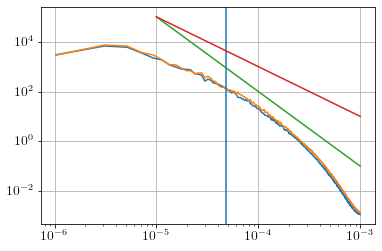

In [259]:
plt.loglog(specup_WC.ki,KESPEC_WC)
plt.plot(specup_NC.ki,KESPEC_NC)
#plt.plot(specup_IC.ki,KESPEC_IC, color='k', linestyle='--')
plt.axvline(1/(0.7*30e3))
plt.grid()

k3 = np.array([specup_NC.ki[-1]/100,specup_NC.ki[-1]])
E3 = 1/k3**3/1e10
E2 = k3*E3
E2 = E2/E2[0]*E3[0]

plt.plot(k3, E3)
plt.plot(k3, E2)

(0, 0.02)

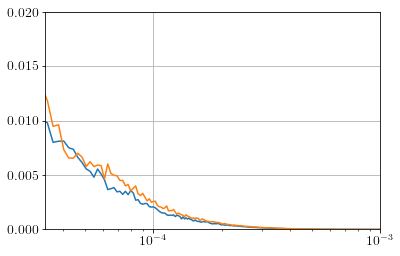

In [260]:
# Only submesoscale range
plt.semilogx(specup_WC.ki,KESPEC_WC*specup_WC.ki)
plt.plot(specup_NC.ki,KESPEC_NC*specup_NC.ki)

plt.grid()

k3 = np.array([specup_NC.ki[-1]/10,specup_NC.ki[-1]])
E3 = 1/k3**3/1e10
#plt.plot(k3, E3)
plt.xlim(1/30e3, 1e-3)
#plt.ylim(1e-3, 1e3)
plt.ylim(0, 2e-2)

Ratio of KE: 0.870705025201072


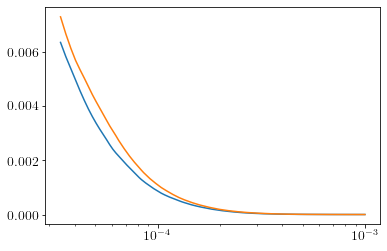

In [261]:
# Plot KE Ogive
plt.figure()
ogive = -integrate.cumtrapz(KESPEC_WC, x=specup_WC.ki, initial=0)+integrate.trapz(KESPEC_WC, x=specup_WC.ki)
wavelength = 30e3 # 30 km is first baroclinic
ind = np.argmin(np.abs(specup_WC.ki-1/wavelength))
norm = ogive[ind]
norm = 1
ogiveWC = ogive/norm
plt.semilogx(specup_WC.ki[ind:], ogiveWC[ind:])

ogive = -integrate.cumtrapz(KESPEC_NC, x=specup_NC.ki, initial=0)+integrate.trapz(KESPEC_NC, x=specup_NC.ki)
#wavelength = 50e3 # 30 km is first baroclinic
ind = np.argmin(np.abs(specup_NC.ki-1/wavelength))
ogiveNC = ogive/norm
plt.semilogx(specup_NC.ki[ind:], ogiveNC[ind:])

print(f'Ratio of KE: {ogiveWC[ind]/ogiveNC[ind]}')

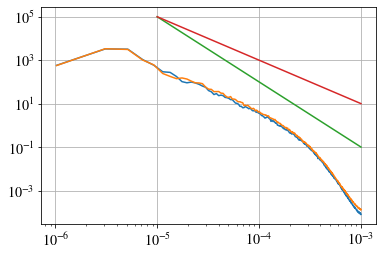

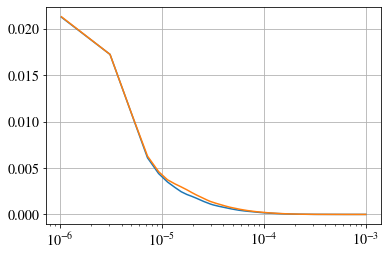

In [409]:
# Buoyancy spectrum
TS = -12
ZS = -1
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
specb_WC = spec.TWODimensional_spec(np.array(dsWC.rho.isel(ocean_time=TS, s_rho=ZS)[:,:]),dx,dy)
specb_NC = spec.TWODimensional_spec(np.array(dsNC.rho.isel(ocean_time=TS, s_rho=ZS)[:,:]),dx,dy)

plt.loglog(specb_WC.ki, specb_WC.ispec)
plt.loglog(specb_NC.ki, specb_NC.ispec)
plt.grid()

k3 = np.array([specup_NC.ki[-1]/100,specup_NC.ki[-1]])
E3 = 1/k3**3/1e10
E2 = k3*E3
E2 = E2/E2[0]*E3[0]

plt.plot(k3, E3)
plt.plot(k3, E2)


plt.figure()
ogive = -integrate.cumtrapz(specb_WC.ispec, x=specb_WC.ki, initial=0)+integrate.trapz(specb_WC.ispec, x=specb_WC.ki)
plt.semilogx(specb_WC.ki, ogive)
ogive = -integrate.cumtrapz(specb_NC.ispec, x=specb_NC.ki, initial=0)+integrate.trapz(specb_NC.ispec, x=specb_NC.ki)
plt.semilogx(specb_NC.ki, ogive)
plt.grid()



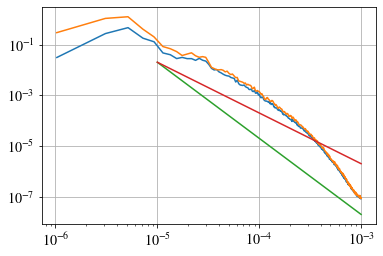

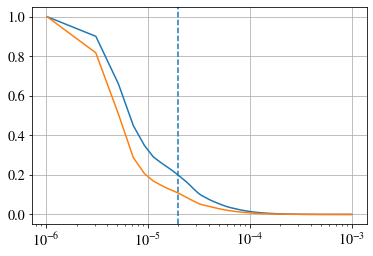

In [397]:
# Wind stress spectra

TS = -12
ZS = -1
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
spectaux_WC = spec.TWODimensional_spec(np.array(dsWC.sustr[TS,:,:-1]),dx,dy)
spectauy_WC = spec.TWODimensional_spec(np.array(dsWC.svstr[TS,:-1,:]),dx,dy)

spectaux_NC = spec.TWODimensional_spec(np.array(dsNC.sustr[TS,:,:-1]),dx,dy)

plt.loglog(spectaux_WC.ki, spectaux_WC.ispec)
plt.loglog(spectauy_WC.ki, spectauy_WC.ispec)

k3 = np.array([specup_NC.ki[-1]/100,specup_NC.ki[-1]])
E3 = 1/k3**3/5e16
E2 = k3*E3
E2 = E2/E2[0]*E3[0]

plt.plot(k3, E3)
plt.plot(k3, E2)
plt.grid()

# Plot as ogive
plt.figure()
ogive = -integrate.cumtrapz(spectaux_WC.ispec, x=spectaux_WC.ki, initial=0)+integrate.trapz(spectaux_WC.ispec, x=spectaux_WC.ki)
ogive = ogive/np.max(ogive)
plt.semilogx(spectaux_WC.ki, ogive)

ogive = -integrate.cumtrapz(spectauy_WC.ispec, x=spectauy_WC.ki, initial=0)+integrate.trapz(spectauy_WC.ispec, x=spectauy_WC.ki)
ogive = ogive/np.max(ogive)
plt.semilogx(spectauy_WC.ki, ogive)

plt.grid()
plt.axvline(1/50e3, linestyle='dashed') # quickscat resolution is ~25km so spectral res is 1/50km
#plt.loglog(spectaux_NC.ki, spectaux_NC.ispec)

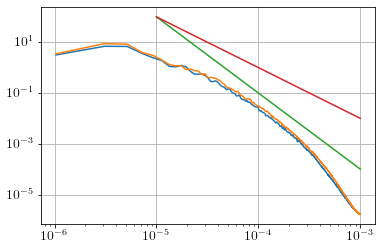

In [264]:
# Wind Work spectrum
# Here calculated by taking the spectra of tau dot u 
# Should I do this as a co-spectra?

# Wind work
TS = -1
txw = dsWC.sustr*dsWC.u.isel(s_rho=-1)
tyw = dsWC.svstr*dsWC.v.isel(s_rho=-1)
txw_spec = spec.TWODimensional_spec(np.array(txw[TS,:,:-1]),dx,dy)
tyw_spec = spec.TWODimensional_spec(np.array(tyw[TS,:-1,:]),dx,dy)
wwspec_WC = txw_spec.ispec + tyw_spec.ispec[0:-1]

txw = dsNC.sustr*dsNC.u.isel(s_rho=-1)
tyw = dsNC.svstr*dsNC.v.isel(s_rho=-1)
txw_spec = spec.TWODimensional_spec(np.array(txw[TS,:,:-1]),dx,dy)
tyw_spec = spec.TWODimensional_spec(np.array(tyw[TS,:-1,:]),dx,dy)
wwspec_NC = txw_spec.ispec + tyw_spec.ispec[0:-1]

plt.loglog(txw_spec.ki, wwspec_WC)
plt.loglog(txw_spec.ki, wwspec_NC)

#plt.plot(dsNC.ocean_time/86400, ww_NC)
k3 = np.array([specup_NC.ki[-1]/100,specup_NC.ki[-1]])
E3 = 1/k3**3/1e13
E2 = k3*E3
E2 = E2/E2[0]*E3[0]

plt.plot(k3, E3)
plt.plot(k3, E2)

plt.grid()

(4002, 1000)
(4000, 1002)
(4002, 1000)
(4000, 1002)


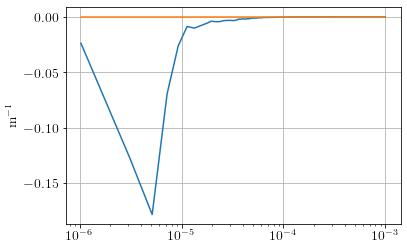

In [265]:
# Wind Work spectrum as Co Spectra


# Wind work
TS = -15
txw = dsWC.sustr*dsWC.u.isel(s_rho=-1)
tyw = dsWC.svstr*dsWC.v.isel(s_rho=-1)
txw_spec = spec.CO_TWODimensional_spec(np.array(dsWC.u.isel(s_rho=-1)[TS,:,:-1]),np.array(dsWC.sustr[TS,:,:-1])/1030,dx,dy)
tyw_spec = spec.CO_TWODimensional_spec(np.array(dsWC.v.isel(s_rho=-1)[TS,:-1,:]),np.array(dsWC.svstr[TS,:-1,:])/1030,dx,dy)
wwspec_WC = txw_spec.ispec + tyw_spec.ispec[0:-1]

txw = dsNC.sustr*dsNC.u.isel(s_rho=-1)
tyw = dsNC.svstr*dsNC.v.isel(s_rho=-1)
txw_spec = spec.CO_TWODimensional_spec(np.array(dsNC.u.isel(s_rho=-1)[TS,:,:-1]),np.array(dsNC.sustr[TS,:,:-1])/1030,dx,dy)
tyw_spec = spec.CO_TWODimensional_spec(np.array(dsNC.v.isel(s_rho=-1)[TS,:-1,:]),np.array(dsNC.svstr[TS,:-1,:])/1030,dx,dy)
wwspec_NC = txw_spec.ispec + tyw_spec.ispec[0:-1]

plt.semilogx(txw_spec.ki, wwspec_WC)
plt.semilogx(txw_spec.ki, wwspec_NC)

#plt.plot(dsNC.ocean_time/86400, ww_NC)
plt.ylabel('m$^{-1}$')
plt.grid()
#plt.yscale('symlog')
#plt.ylim(-1e-3,0)

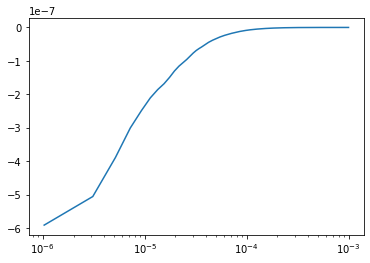

In [82]:
plt.semilogx(txw_spec.ki, -integrate.cumtrapz(wwspec_WC, x=txw_spec.ki, initial=0)+integrate.trapz(wwspec_WC, x=txw_spec.ki))

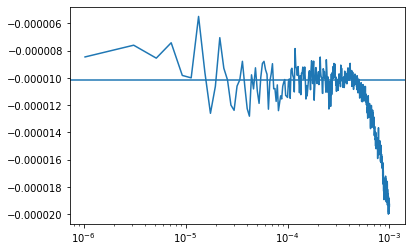

In [83]:
# Ratio of wind work to KE
plt.semilogx(txw_spec.ki, wwspec_WC/KESPEC_WC)
plt.axhline(-1e-3/1035 *(1.4*5)*3/2)

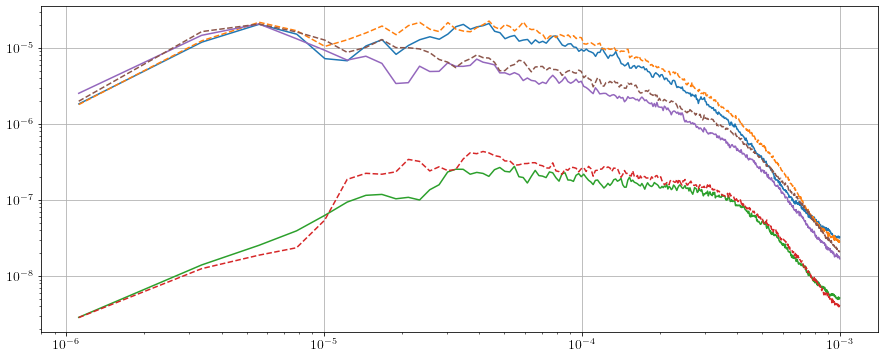

In [279]:
# Vorticity and divergence spectra
TS = -15
ZS = -3

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
specvort_WC = spec.TWODimensional_spec(np.array(dsWC.vort.isel(s_rho=ZS, ocean_time=TS, eta_v=yl)[:,:-1]),dx,dy)
specvort_NC = spec.TWODimensional_spec(np.array(dsNC.vort.isel(s_rho=ZS, ocean_time=TS, eta_v=yl)[:,:-1]),dx,dy)

specdiv_WC = spec.TWODimensional_spec(np.array(dsWC.div.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)
specdiv_NC = spec.TWODimensional_spec(np.array(dsNC.div.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)


specstrain_WC = spec.TWODimensional_spec(np.array(dsWC.strain.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)
specstrain_NC = spec.TWODimensional_spec(np.array(dsNC.strain.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)


plt.figure(figsize=(15,6))
plt.loglog(specvort_WC.ki, specvort_WC.ispec)
plt.loglog(specvort_NC.ki, specvort_NC.ispec, linestyle='--')

plt.loglog(specdiv_WC.ki, specdiv_WC.ispec)
plt.loglog(specdiv_NC.ki, specdiv_NC.ispec, linestyle='--')

plt.loglog(specstrain_WC.ki, specstrain_WC.ispec)
plt.loglog(specstrain_NC.ki, specstrain_NC.ispec, linestyle='--')

plt.grid()

Ratio of vorticity: 0.7763421254840824
Ratio of divergence: 0.7904462464213657
Ratio of strain: 0.7196486979767795


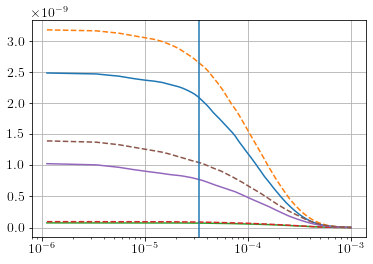

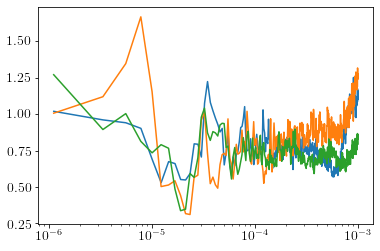

In [284]:
forward = False

if forward:
    vortog_WC = integrate.cumtrapz(specvort_WC.ispec,x=specvort_WC.ki, initial=0) 
    vortog_NC = integrate.cumtrapz(specvort_NC.ispec,x=specvort_NC.ki, initial=0) 
else:
    vortog_WC = -integrate.cumtrapz(specvort_WC.ispec,x=specvort_WC.ki, initial=0) + integrate.trapz(specvort_WC.ispec, x=specvort_WC.ki)
    vortog_NC = -integrate.cumtrapz(specvort_NC.ispec,x=specvort_NC.ki, initial=0) + integrate.trapz(specvort_NC.ispec, x=specvort_NC.ki)
plt.semilogx(specvort_WC.ki, vortog_WC)
plt.semilogx(specvort_NC.ki, vortog_NC, linestyle='--')

if forward:
    divog_WC = integrate.cumtrapz(specdiv_WC.ispec,x=specdiv_WC.ki, initial=0) 
    divog_NC = integrate.cumtrapz(specdiv_NC.ispec,x=specdiv_NC.ki, initial=0) 
else:
    divog_WC = -integrate.cumtrapz(specdiv_WC.ispec,x=specdiv_WC.ki, initial=0) + integrate.trapz(specdiv_WC.ispec, x=specdiv_WC.ki)
    divog_NC = -integrate.cumtrapz(specdiv_NC.ispec,x=specdiv_NC.ki, initial=0) + integrate.trapz(specdiv_NC.ispec, x=specdiv_NC.ki)
plt.semilogx(specdiv_WC.ki, divog_WC)
plt.semilogx(specdiv_NC.ki, divog_NC, linestyle='--')

if forward:
    strainog_WC = integrate.cumtrapz(specstrain_WC.ispec,x=specstrain_WC.ki, initial=0)
    strainog_NC = integrate.cumtrapz(specstrain_NC.ispec,x=specstrain_NC.ki, initial=0) 
else:
    strainog_WC = -integrate.cumtrapz(specstrain_WC.ispec,x=specstrain_WC.ki, initial=0) + integrate.trapz(specstrain_WC.ispec, x=specstrain_WC.ki)
    strainog_NC = -integrate.cumtrapz(specstrain_NC.ispec,x=specstrain_NC.ki, initial=0) + integrate.trapz(specstrain_NC.ispec, x=specstrain_NC.ki)
plt.semilogx(specstrain_WC.ki, strainog_WC)
plt.semilogx(specstrain_NC.ki, strainog_NC, linestyle='--')

plt.axvline(1/30e3)
plt.grid()
#plt.xlim(1e-5, 1e-3)

wavelength = 100e3
ind = np.argmin(np.abs(specstrain_WC.ki - 1/wavelength))
print(f'Ratio of vorticity: {vortog_WC[ind]/vortog_NC[ind]}')
print(f'Ratio of divergence: {divog_WC[ind]/divog_NC[ind]}')
print(f'Ratio of strain: {strainog_WC[ind]/strainog_NC[ind]}')

plt.figure()
plt.semilogx(specvort_WC.ki, specvort_WC.ispec/specvort_NC.ispec)
plt.semilogx(specdiv_WC.ki, specdiv_WC.ispec/specdiv_NC.ispec)

plt.semilogx(specstrain_WC.ki, specstrain_WC.ispec/specstrain_NC.ispec)


Ratio of coupled/uncoupled w variance: 0.6644088451199549


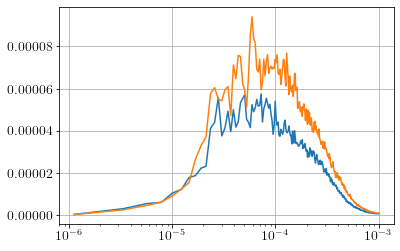

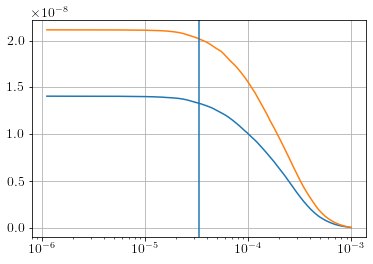

In [269]:
# Vertical Velocity Spectra

TS = -12
ZS = -3

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
specw_WC = spec.TWODimensional_spec(np.array(dsWC.w.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)
specw_NC = spec.TWODimensional_spec(np.array(dsNC.w.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)

plt.semilogx(specw_WC.ki, specw_WC.ispec)
plt.semilogx(specw_NC.ki, specw_NC.ispec)
plt.grid()

plt.figure() # Cumulative
plt.semilogx(specw_WC.ki, -integrate.cumtrapz(specw_WC.ispec,x=specw_WC.ki, initial=0) + integrate.trapz(specw_WC.ispec, x=specw_WC.ki))
plt.semilogx(specw_NC.ki, -integrate.cumtrapz(specw_NC.ispec,x=specw_NC.ki, initial=0) + integrate.trapz(specw_NC.ispec, x=specw_NC.ki))

plt.axvline(1/30e3)
plt.grid()
print(f'Ratio of coupled/uncoupled w variance: {integrate.trapz(specw_WC.ispec, x=specw_WC.ki)/integrate.trapz(specw_NC.ispec, x=specw_NC.ki)}')

Ratio of coupled/uncoupled EBF variance: 0.6312142134363076


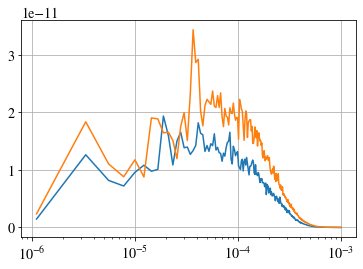

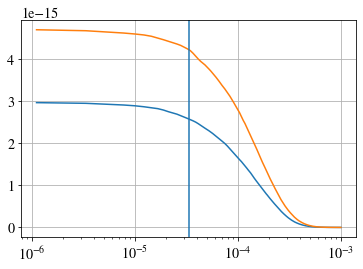

In [398]:
# EBF spectrum
# Vertical Velocity Spectra

TS = -1
ZS = -3

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
specebf_WC = spec.TWODimensional_spec(np.array(dsWC.EBF.isel( ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)
specebf_NC = spec.TWODimensional_spec(np.array(dsNC.EBF.isel( ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)

plt.semilogx(specebf_WC.ki, specebf_WC.ispec)
plt.semilogx(specebf_NC.ki, specebf_NC.ispec)
plt.grid()


plt.figure() # Cumulative
plt.semilogx(specebf_WC.ki, -integrate.cumtrapz(specebf_WC.ispec,x=specebf_WC.ki, initial=0) + integrate.trapz(specebf_WC.ispec, x=specebf_WC.ki))
plt.semilogx(specebf_NC.ki, -integrate.cumtrapz(specebf_NC.ispec,x=specebf_NC.ki, initial=0) + integrate.trapz(specebf_NC.ispec, x=specebf_NC.ki))

plt.axvline(1/30e3)
plt.grid()
print(f'Ratio of coupled/uncoupled EBF variance: {integrate.trapz(specebf_WC.ispec, x=specebf_WC.ki)/integrate.trapz(specebf_NC.ispec, x=specebf_NC.ki)}')

In [ ]:
TS = -1
ZS = -1

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx

b = np.array(-9.8/1020*dsWC.rho.isel(ocean_time=TS, s_rho=ZS))
tx = np.array(xroms.to_rho(dsWC.sustr.isel(ocean_time=TS),grid))/(1e-3*7)
ty = np.array(xroms.to_rho(dsWC.svstr.isel(ocean_time=TS),grid))/(1e-3*7)

specebf_WC = spec.CO_TWODimensional_spec(b, tx,dx,dy)
specebfy_WC = spec.CO_TWODimensional_spec(b, ty,dx,dy)

tx = np.array(xroms.to_rho(dsWC.sustr.isel(ocean_time=TS),grid))
ty = np.array(xroms.to_rho(dsWC.svstr.isel(ocean_time=TS),grid))

#specebf_WC = spec.CO_TWODimensional_spec(b, 7+0*tx,dx,dy)
#specebfy_WC = spec.CO_TWODimensional_spec(b, 7 +0*ty,dx,dy)

#specebf_NC = spec.TWODimensional_spec(np.array(dsNC.EBF.isel( ocean_time=TS, eta_rho=yl)[:,:]),dx,dy)

/homes/metofac/wenegrat/miniconda3/envs/AIRSEA/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


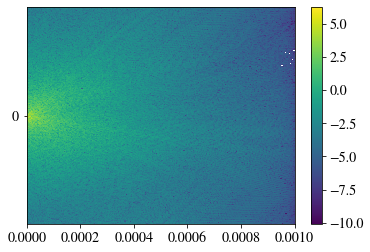

In [34]:
plt.pcolormesh(specebf_WC.kk1, specebf_WC.kk2, np.log10((specebf_WC.cospec)))
plt.colorbar()
plt.yscale('symlog', linthreshx=1/100e3)
#plt.xscale('log')

/homes/metofac/wenegrat/miniconda3/envs/AIRSEA/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/homes/metofac/wenegrat/miniconda3/envs/AIRSEA/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


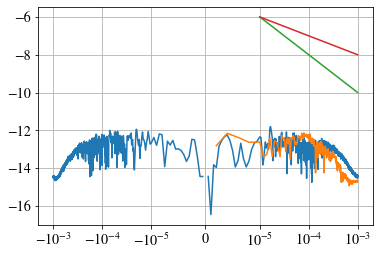

In [45]:
plt.figure()
spec_int_x = integrate.trapz(specebf_WC.cospec, x=specebf_WC.kk1, axis=1)
spec_int_y = integrate.trapz(specebfy_WC.cospec, x=specebfy_WC.kk2, axis=0)

plt.plot(specebf_WC.kk2[:,0], np.log10(np.abs(spec_int_x *specebf_WC.kk2[:,0]**2)))
plt.plot(specebfy_WC.kk1[0,:], np.log10(np.abs(spec_int_y*specebfy_WC.kk1[0,:]**2)))


k3 = np.array([specebf_WC.kk2[-1,0]/100,specebf_WC.kk2[-1,0]])
E3 = 1/k3**2/1e16
E2 = k3*E3
E2 = E2/E2[0]*E3[0]

plt.plot(k3, np.log10(E3))
plt.plot(k3, np.log10(E2))
plt.xscale('symlog', linthreshx=1/100e3)

plt.grid()

In [49]:
TS = -1
ZS=-1
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
b = np.array(-9.8/1020*dsWC.rho.isel(ocean_time=TS, s_rho=ZS))
ubspec = spec.CO_TWODimensional_spec(np.array(xroms.to_rho(dsWC.u.isel(s_rho=-1, ocean_time=TS),grid).values),b,dx,dy, detrend=False)
bspec = spec.TWODimensional_spec(b, dx, dy, detrend=False)
#plt.loglog(uspec.ki, uspec.cospec)

(4002, 1002)


(-0.001, 0.001)

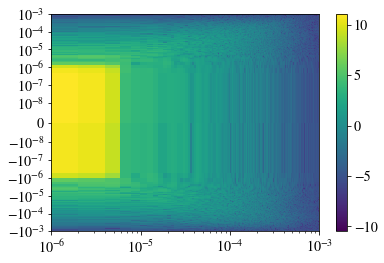

In [51]:
plt.pcolormesh(bspec.kk1, bspec.kk2, np.log10((bspec.spec)))
plt.colorbar()
plt.yscale('symlog', linthreshy=1/100000e3)
plt.xscale('log')
plt.xlim(1e-6, 1e-3)
plt.ylim(-1e-3, 1e-3)

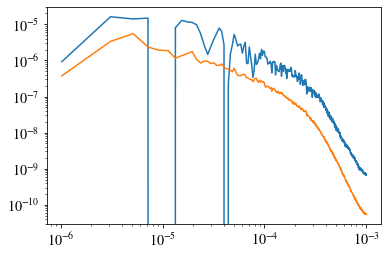

In [20]:
#plt.semilogx(ubspec.ki, ubspec.ispec)
plt.semilogx(ubspec.ki, -ubspec.ispecq*ubspec.ki)
plt.semilogx(bspec.ki, 7*bspec.ispec*bspec.ki)

#plt.yscale('symlog', linthreshx=1e-10)
plt.yscale('log')


In [ ]:
# Wind work
TS = -15
bx = grid.derivative()
txw_spec = spec.CO_TWODimensional_spec(np.array(dsWC.u.isel(s_rho=-1)[TS,:,:-1]),np.array(dsWC.sustr[TS,:,:-1])/1030,dx,dy)
tyw_spec = spec.CO_TWODimensional_spec(np.array(dsWC.v.isel(s_rho=-1)[TS,:-1,:]),np.array(dsWC.svstr[TS,:-1,:])/1030,dx,dy)


(2000, 1002)
(2000, 1002)
Ratio of coupled/uncoupled wb variance: 0.8305034061819293


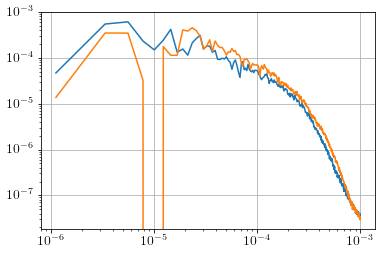

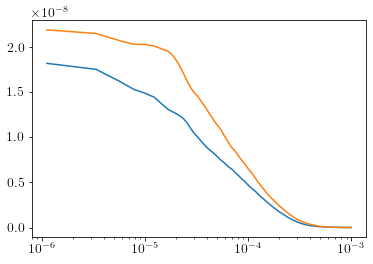

In [270]:
# Vert B Flux Spectra

# Vorticity and divergence spectra
TS = -12
ZS = -3

#yl = slice(750,1500)
dx = dsWC.dx.isel(eta_rho=0, xi_rho=0).values
dy = dx
b = np.array(-9.8/1035*dsWC.rho.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl))
specwb_WC = spec.CO_TWODimensional_spec(np.array(dsWC.w.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)
b = np.array(-9.8/1035*dsNC.rho.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl))
specwb_NC = spec.CO_TWODimensional_spec(np.array(dsNC.w.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)

plt.loglog(specwb_WC.ki, specwb_WC.ispec)
plt.loglog(specwb_NC.ki, specwb_NC.ispec)
plt.grid()

plt.figure() # Cumulative
fNC = integrate.trapz(specwb_NC.ispec, x=specwb_NC.ki)
fWC = integrate.trapz(specwb_WC.ispec, x=specwb_WC.ki)
plt.semilogx(specwb_WC.ki, -integrate.cumtrapz(specwb_WC.ispec,x=specwb_WC.ki, initial=0) + fWC)
plt.semilogx(specwb_NC.ki, -integrate.cumtrapz(specwb_NC.ispec,x=specwb_NC.ki, initial=0) + fNC)

print(f'Ratio of coupled/uncoupled wb variance: {fWC/fNC}')

(2000, 1000)
(2000, 1002)


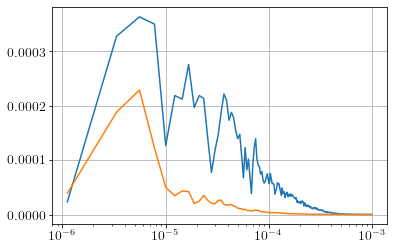

In [288]:
b = np.array(-9.8/1035*dsWC.rho.isel(s_rho=-1, ocean_time=TS, eta_rho=yl))
wek = grid.derivative(-dsWC.sustr.isel(ocean_time=TS), 'Y')/(1035*1e-4) + grid.derivative(dsWC.svstr.isel(ocean_time=TS),'X')/(1035*1e-4)


specwe_WC = spec.CO_TWODimensional_spec(np.array(wek.isel(eta_v=yl)[:,:-1]), b[:,1:-1],dx,dy)
specwb_WC = spec.CO_TWODimensional_spec(np.array(dsWC.w.isel(s_rho=ZS, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)

plt.semilogx(specwb_WC.ki, specwb_WC.ispec)
plt.semilogx(specwe_WC.ki, specwe_WC.ispec)

#plt.xlim(5e-5, 1e-3)
#plt.ylim(-1e-5, 1e-5)
plt.grid()

In [102]:
DeltZ = dsWC.dz[0,:,0,0].values
TS = -15
b = np.array(-9.8/1035*dsWC.rho.isel(s_rho=-1, ocean_time=TS, eta_rho=yl))
specwb_WC = spec.CO_TWODimensional_spec(np.array(dsWC.w.isel(s_rho=-1, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)
ispec = specwb_WC.ispec*DeltZ[-1]

b = np.array(-9.8/1035*dsNC.rho.isel(s_rho=-1, ocean_time=TS, eta_rho=yl))
specwb_NC = spec.CO_TWODimensional_spec(np.array(dsNC.w.isel(s_rho=-1, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)
ispec_NC = specwb_NC.ispec*DeltZ[-1]
for i in range(53, 58):
    print(i)
    b = np.array(-9.8/1035*dsWC.rho.isel(s_rho=i, ocean_time=TS, eta_rho=yl))
    specwb_WC = spec.CO_TWODimensional_spec(np.array(dsWC.w.isel(s_rho=i, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)
    ispec += specwb_WC.ispec*DeltZ[i]
    
    b = np.array(-9.8/1035*dsNC.rho.isel(s_rho=i, ocean_time=TS, eta_rho=yl))
    specwb_NC = spec.CO_TWODimensional_spec(np.array(dsNC.w.isel(s_rho=i, ocean_time=TS, eta_rho=yl)[:,:]), b,dx,dy)
    ispec_NC += specwb_NC.ispec*DeltZ[i]

(1000, 1002)
(1000, 1002)
53
(1000, 1002)
(1000, 1002)
54
(1000, 1002)
(1000, 1002)
55
(1000, 1002)
(1000, 1002)
56
(1000, 1002)
(1000, 1002)
57
(1000, 1002)
(1000, 1002)


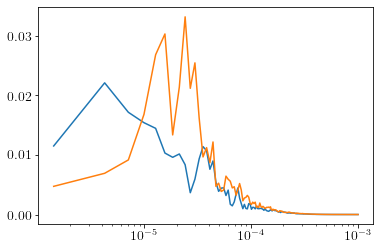

In [103]:
plt.semilogx(specwb_WC.ki, ispec)
plt.semilogx(specwb_WC.ki, ispec_NC)

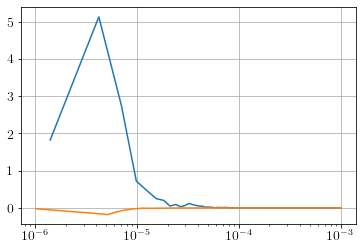

In [247]:
plt.semilogx(specwb_WC.ki, ispec)

plt.semilogx(txw_spec.ki, wwspec_WC)
plt.grid()
#plt.xlim(1e-5, 1e-3)
#plt.ylim(-2e-2, 2e-2)

In [263]:
dsWC.dz[0,-1,0,0].values

array(6.0516024, dtype=float32)

(-1000, 0)

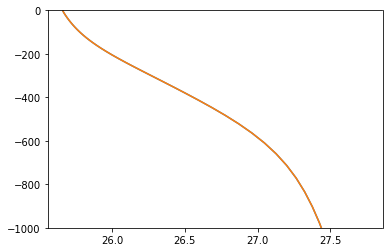

In [215]:
# Are the density profiles different?

TS = 0
yl = slice(750,1500)
zr = dsWC.z_rho.isel(ocean_time=TS).mean(dim=('xi_rho', 'eta_rho'))
plt.plot(dsWC.rho.isel(ocean_time=TS, eta_rho=yl).mean(dim=('xi_rho', 'eta_rho')), zr)
plt.plot(dsNC.rho.isel(ocean_time=TS, eta_rho=yl).mean(dim=('xi_rho', 'eta_rho')), zr)
plt.ylim(-1000,0)

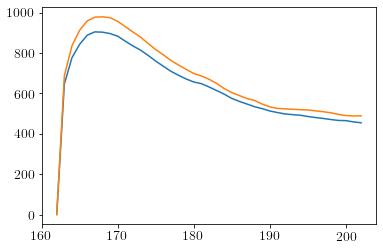

In [235]:
plt.plot(dsWC.ocean_time/86400, dsWC.hbl.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))
plt.plot(dsNC.ocean_time/86400, dsNC.hbl.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho')))

## Idealized Tests

(-2000.0, 2000.0, -2000.0, 2000.0)

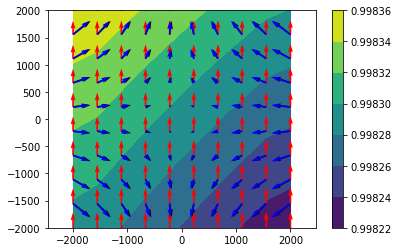

In [246]:
# Check if strain field is effected by perturbation Ekman transport

alpha = 1e-4
x = np.linspace(-2e3, 2e3, 10)
y = np.linspace(-2e3, 2e3, 10)
X, Y = np.meshgrid(x,y)
u = -alpha * X
v = alpha* Y

taux = 1e-3*np.sqrt( (5-u)**2 + (5-v)**2)*(5-u)
tauy = 1e-3*np.sqrt( (5-u)**2 + (5-v)**2)*(5-v)
taux = 0*taux
MLD = 20
uek = -tauy/1035/1e-4/MLD
vek = taux/1035/1e-4/MLD

conv = np.gradient(uek, axis=1)/np.gradient(X, axis=1) + 0*np.gradient(vek, axis=0)/np.gradient(Y, axis=0) + alpha

ix=plt.contourf(X,Y, conv/alpha)
plt.quiver(X, Y, u, v)
plt.quiver(X, Y, taux, tauy, color='r')
plt.quiver(X, Y, u+uek, v+vek, color='b')

plt.colorbar(ix)
plt.axis('equal')

In [76]:
theta = np.linspace(0, 2*np.pi, 100)
#np.mean(np.sin(thetab))
np.mean(np.sin(np.pi/4 - thetab)).values

array(0.10483705, dtype=float32)

Text(0.5, 1.0, '14.307919485409343')

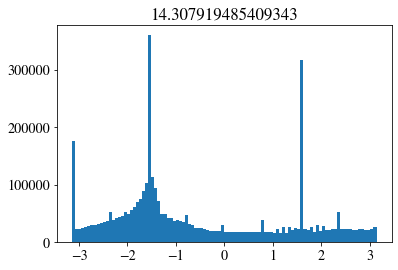

In [84]:
TS = 40
bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), grid)
bmag = np.sqrt(bx**2 + by**2)
thetab = np.arctan2(by.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')), bx.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')))
thetab.plot.hist(bins=100)                  
plt.title(3/2/np.average(np.sin(np.pi/4 - thetab.values), ))

Text(0.5, 1.0, '15.750502435685533')

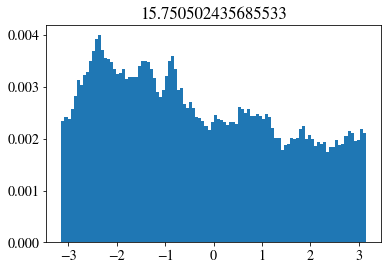

In [86]:
TS = 40
bx = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'X'), grid)
by = xroms.to_rho(-9.8/1020*grid.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), grid)
bmag = np.sqrt(bx**2 + by**2)
thetab = np.arctan2(by.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')), bx.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')))
thetab.plot.hist(bins=100, weights=bmag.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho')))                  
plt.title(3/2/np.average(np.sin(np.pi/4 - thetab.values), weights=bmag.isel(ocean_time=TS).stack(z=('xi_rho', 'eta_rho'))))